In [313]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("/kaggle/input/bank-transaction-data/bank.xlsx")



In [314]:
(df.head(10))

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.
5,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6500000.0,.
6,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,7000000.0,.
7,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,7500000.0,.
8,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,8000000.0,.
9,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,8500000.0,.


In [315]:
non_nan_counts = df.notna().sum()
print("Total non-NaN values in each column:")
print(non_nan_counts)

Total non-NaN values in each column:
Account No             116201
DATE                   116201
TRANSACTION DETAILS    113702
CHQ.NO.                   905
VALUE DATE             116201
WITHDRAWAL AMT          53549
DEPOSIT AMT             62652
BALANCE AMT            116201
.                      116201
dtype: int64


In [316]:
unique_acc = df["Account No"].unique()
print(unique_acc )

["409000611074'" "409000493201'" "409000425051'" "409000405747'"
 "409000438611'" "409000493210'" "409000438620'" "1196711'" "1196428'"
 "409000362497'"]


In [317]:
df['WITHDRAWAL AMT'] = df['WITHDRAWAL AMT'].fillna(0)
df['DEPOSIT AMT'] = df['DEPOSIT AMT'].fillna(0)
df['transaction_amt'] = df['DEPOSIT AMT'] - df['WITHDRAWAL AMT']

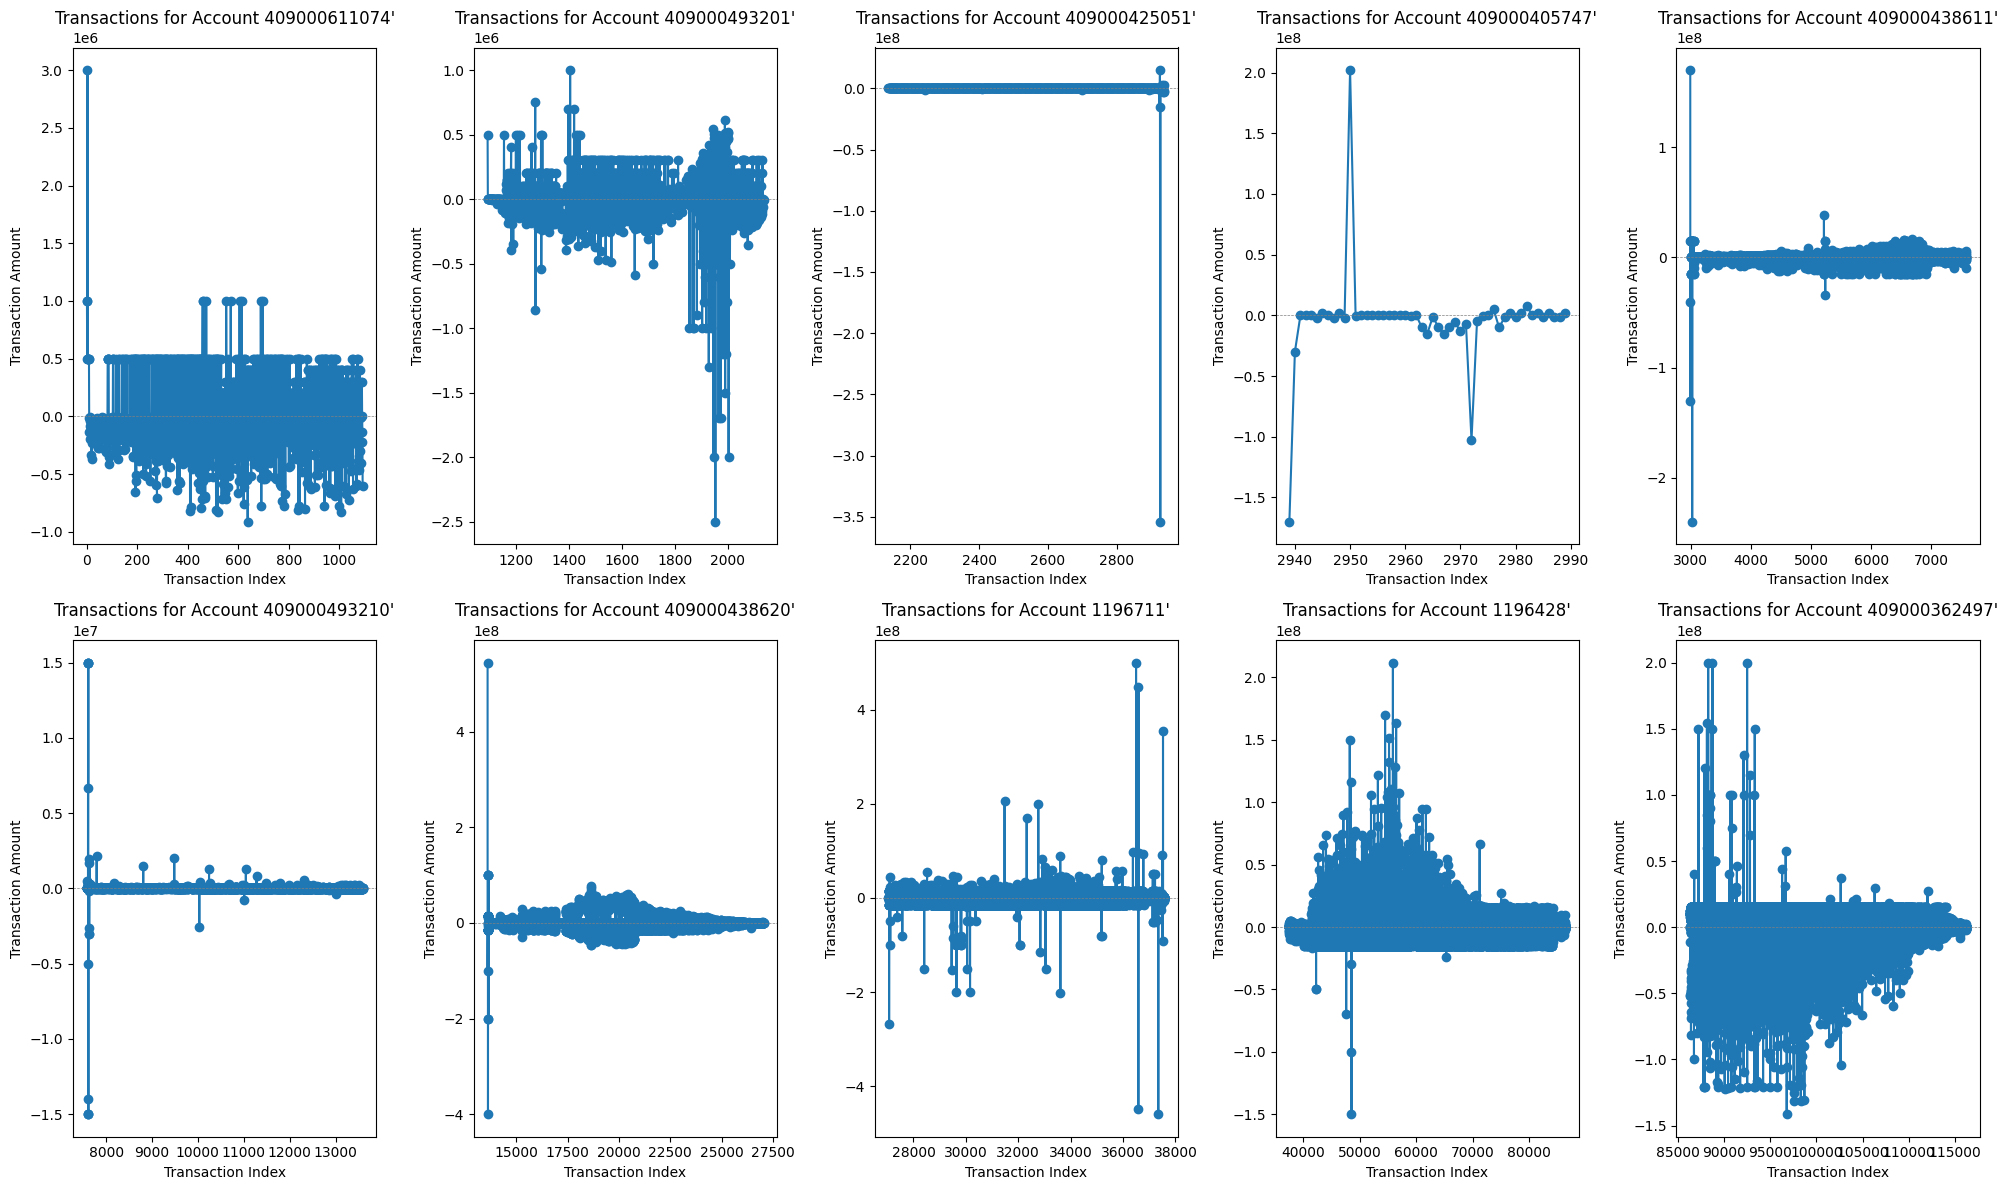

In [318]:
def plot_transactions(ax, df, account_no):
    account_df = df[df['Account No'] == account_no]
    ax.plot(account_df.index, account_df['transaction_amt'], marker='o', linestyle='-')
    ax.set_title(f"Transactions for Account {account_no}")
    ax.set_xlabel('Transaction Index')
    ax.set_ylabel('Transaction Amount')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)


fig, axs = plt.subplots(2, 5, figsize=(20, 12))
axs = axs.flatten()

for i, account_no in enumerate(unique_acc):
    if i < len(axs):
        plot_transactions(axs[i], df, account_no)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [319]:
from scipy.stats import zscore
df['date'] = pd.to_datetime(df['DATE'])


unique_acc = df['Account No'].unique()

df['transaction_amt_zscore'] = df.groupby('Account No')['transaction_amt'].transform(zscore)

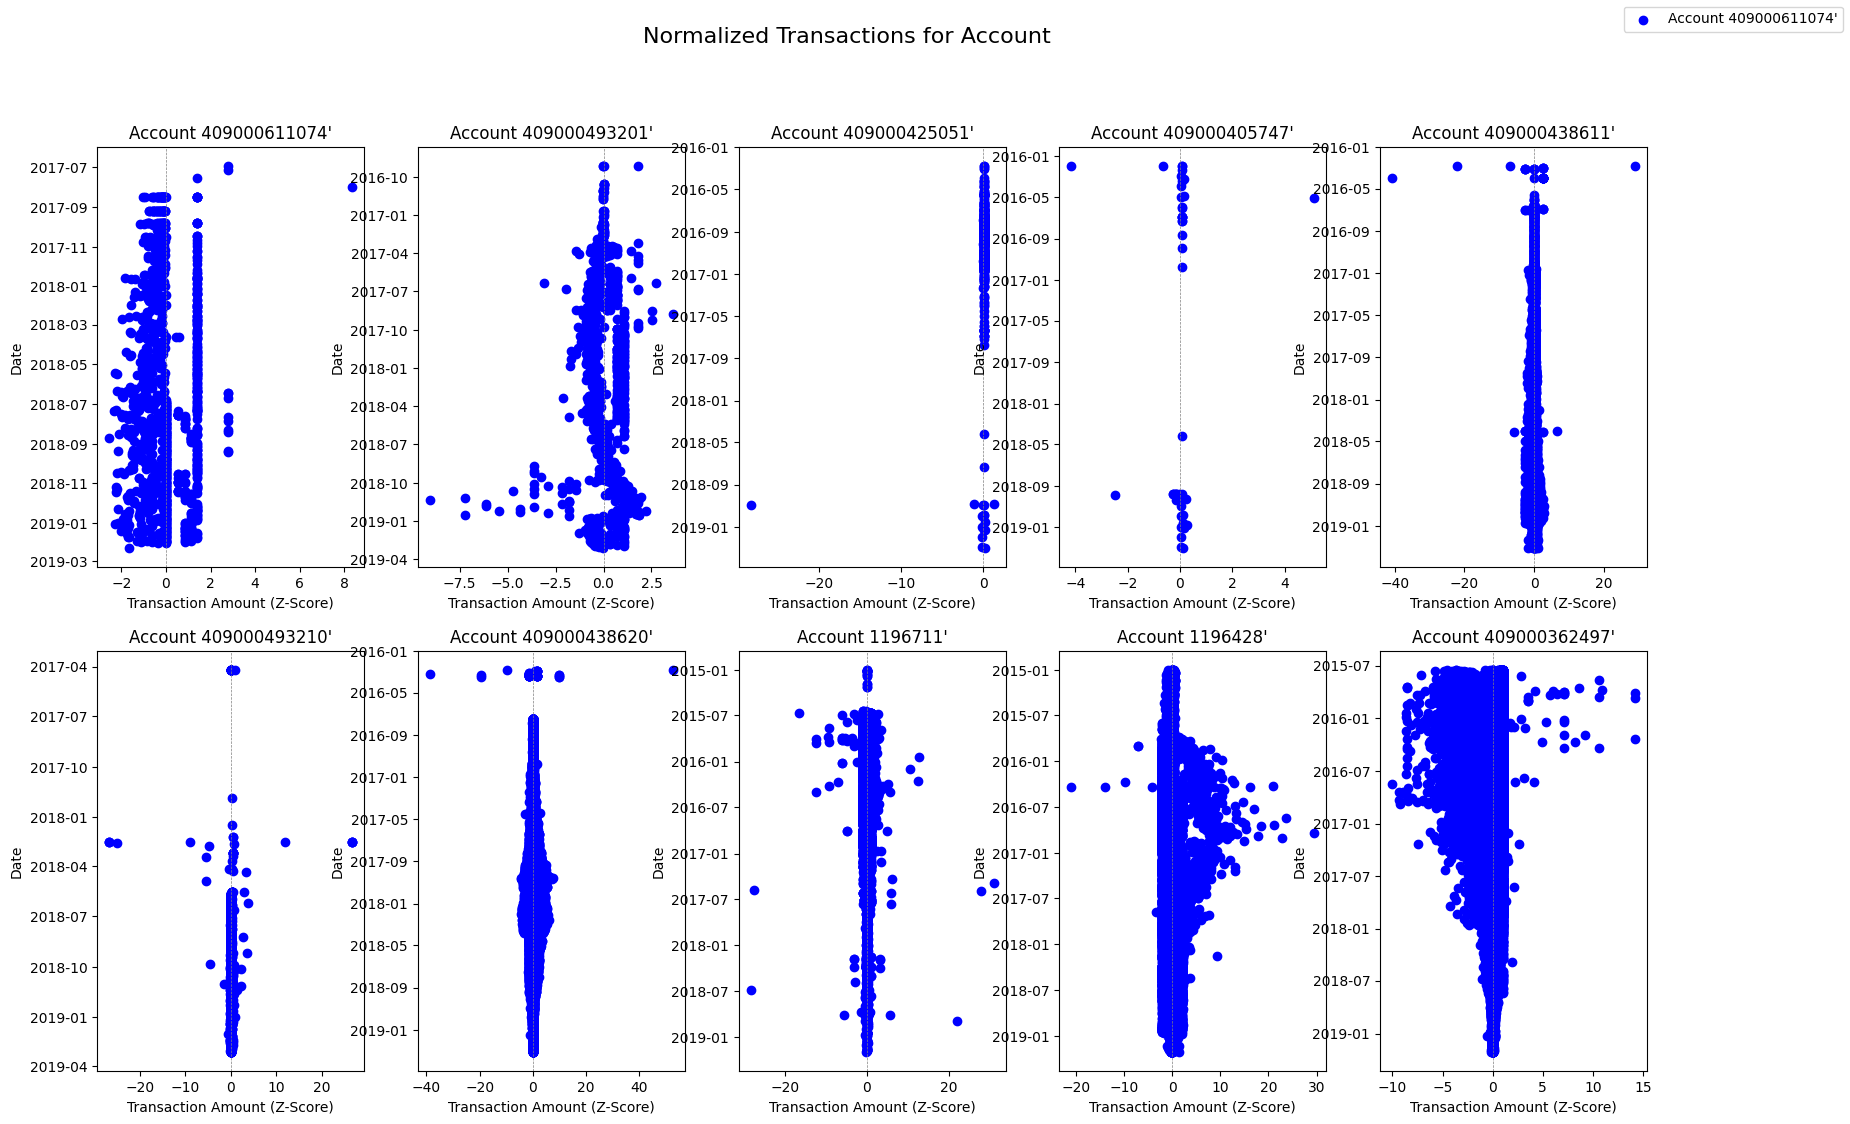

In [320]:
# Create the subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 12))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plotting all transactions on separate graphs for each account
for i, account_no in enumerate(unique_acc):
    account_df = df[df['Account No'] == account_no]
    ax = axs[i]
    
    ax.scatter(account_df['transaction_amt_zscore'], account_df['date'], label=f'Account {account_no}', color='b')
    
    # Adding plot details
    ax.set_title(f"Account {account_no}")
    ax.set_xlabel('Transaction Amount (Z-Score)')
    ax.set_ylabel('Date')
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Add a vertical line at x=0
    ax.invert_yaxis()  # Invert y-axis to have the most recent dates on top

for i in range(len(unique_acc), 10):
    fig.delaxes(axes[i])

fig.suptitle("Normalized Transactions for Account", fontsize=16)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.show()

## Isolation Forest


In [321]:
from sklearn.ensemble import IsolationForest

In [322]:

anomalies = pd.DataFrame()
stats = []

for account_no in unique_acc:
    account_df = df[df['Account No'] == account_no].copy()
    clf = IsolationForest(contamination=0.1, random_state=42)
    account_df['anomaly'] = clf.fit_predict(account_df[['transaction_amt_zscore']])

    normal_transactions = account_df[account_df['anomaly'] == 1]
    min_normal = normal_transactions['transaction_amt_zscore'].min()
    max_normal = normal_transactions['transaction_amt_zscore'].max()
    mean_normal = normal_transactions['transaction_amt_zscore'].mean()
    std_normal = normal_transactions['transaction_amt_zscore'].std()
    anomaly_percentage = (account_df['anomaly'].value_counts()[-1] / len(account_df)) * 100
    
    stats.append({
        'Account No': account_no,
        'min_normal': min_normal,
        'max_normal': max_normal,
        'mean_normal' : mean_normal,
        'std_normal' : std_normal,
        'anomaly_percentage': anomaly_percentage
    })
    
    anomalies = pd.concat([anomalies, account_df])

# Display statistics

stats_df_if = pd.DataFrame(stats)
print('Statistics of IsolationForest Normal Transactions')
(stats_df_if)

Statistics of IsolationForest Normal Transactions


,Account No,min_normal,max_normal,mean_normal,std_normal,anomaly_percentage
0,409000611074',-1.622520,1.391966,0.049420,0.854489,8.234218
1,409000493201',-0.959532,1.197177,0.064821,0.582608,10.057471
2,409000425051',0.035594,0.036569,0.035952,0.000253,9.850374
3,409000405747',-0.280765,0.218619,0.040517,0.117583,9.803922
4,409000438611',-0.866304,0.682703,0.025453,0.287882,10.004359
5,409000493210',-0.018439,0.000064,-0.006421,0.006374,9.876954
6,409000438620',-1.449273,0.330861,-0.038210,0.202769,9.692285
7,1196711',-1.569388,0.988527,-0.002360,0.609973,9.130600
8,1196428',-2.366169,0.946869,-0.125846,0.560642,6.420796
9,409000362497',-0.892835,14.194412,0.219047,0.513819,9.390080


In [323]:
# Calculate and display average values of all columns (except 'Account No')
average_values_if = stats_df_if.drop(columns=['Account No']).mean()
print('\nAverage Performance of Isolated Forest')
print(average_values_if)


Average Performance of Isolated Forest
min_normal           -0.998963
max_normal            1.998777
mean_normal           0.026237
std_normal            0.373639
anomaly_percentage    9.246106
dtype: float64


In [324]:
anomalous_transactions_if = anomalies[anomalies['anomaly'] == -1][['Account No', 'date', 'transaction_amt_zscore']]
print("\nAnomalous Transactions:")
print(anomalous_transactions_if)


Anomalous Transactions:
           Account No       date  transaction_amt_zscore
0       409000611074' 2017-06-29                2.785110
1       409000611074' 2017-07-05                2.785110
3       409000611074' 2017-08-01                8.357688
193     409000611074' 2017-12-19               -1.824799
224     409000611074' 2018-01-10               -1.381093
...               ...        ...                     ...
111616  409000362497' 2018-03-31               -0.887044
111733  409000362497' 2018-04-09               -0.891285
112457  409000362497' 2018-05-14               -0.983984
113159  409000362497' 2018-06-25               -1.035769
113194  409000362497' 2018-06-26                0.972792

[9532 rows x 3 columns]


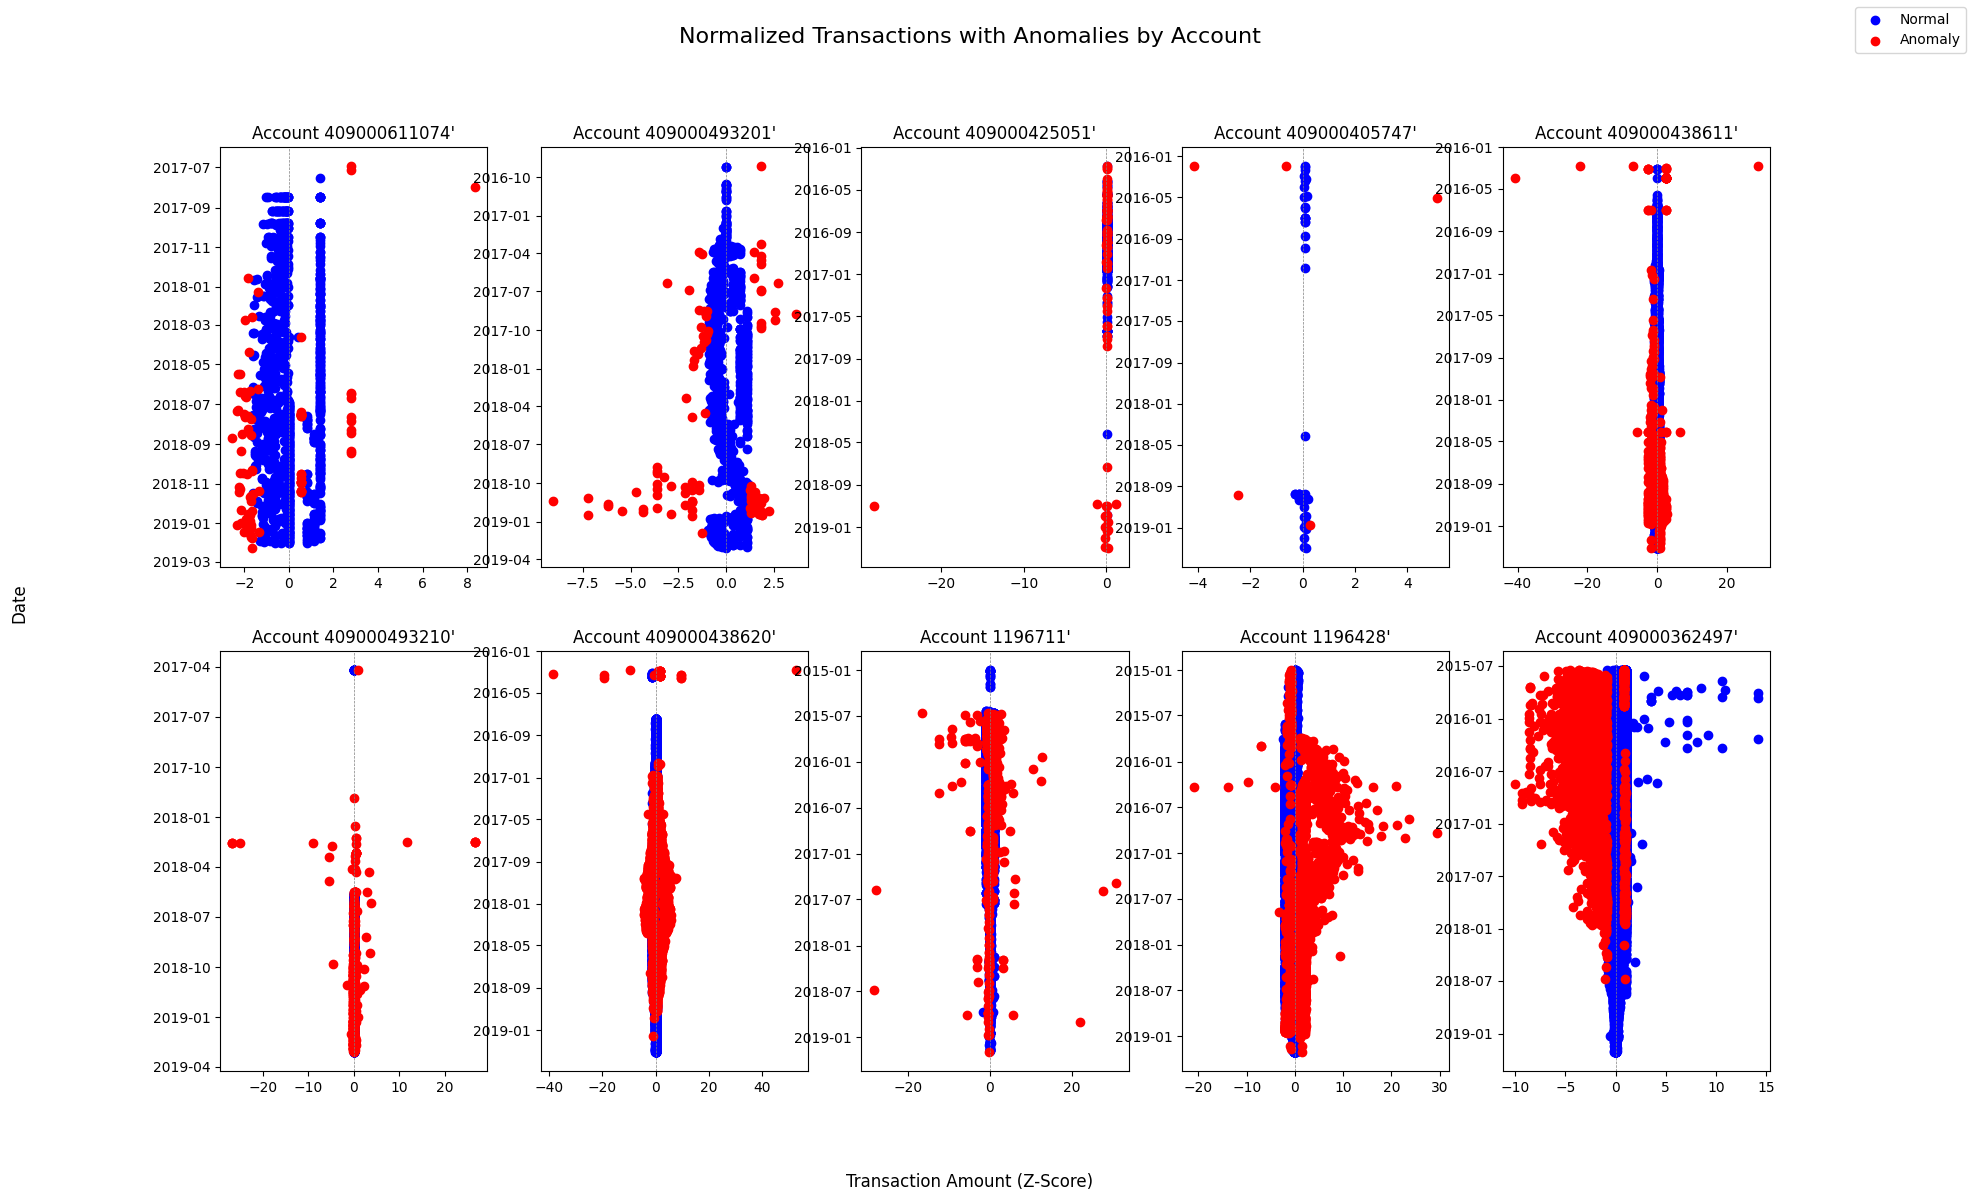

In [325]:
# Plotting anomalies for each account in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(20, 12))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plotting anomalies on separate graphs for each account
for i, account_no in enumerate(unique_acc):
    account_df = anomalies[anomalies['Account No'] == account_no]
    normal = account_df[account_df['anomaly'] == 1]
    anomaly = account_df[account_df['anomaly'] == -1]
    
    ax = axs[i]
    ax.scatter(normal['transaction_amt_zscore'], normal['date'], label='Normal', color='blue')
    ax.scatter(anomaly['transaction_amt_zscore'], anomaly['date'], label='Anomaly', color='red')
    
    # Adding plot details
    ax.set_title(f"Account {account_no}")
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Add a vertical line at x=0
    ax.invert_yaxis()  # Invert y-axis to have the most recent dates on top

# Hide any unused subplots
for i in range(len(unique_acc), 10):
    fig.delaxes(axs[i])

fig.suptitle("Normalized Transactions with Anomalies by Account", fontsize=16)
fig.supxlabel('Transaction Amount (Z-Score)')
fig.supylabel('Date')

# Add a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.show()

## DBSCAN

In [326]:
df.head(10)

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.,transaction_amt,date,transaction_amt_zscore
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,0.0,1000000.0,1000000.0,.,1000000.0,2017-06-29,2.785110
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,0.0,1000000.0,2000000.0,.,1000000.0,2017-07-05,2.785110
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,0.0,500000.0,2500000.0,.,500000.0,2017-07-18,1.391966
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,0.0,3000000.0,5500000.0,.,3000000.0,2017-08-01,8.357688
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,0.0,500000.0,6000000.0,.,500000.0,2017-08-16,1.391966
5,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,0.0,500000.0,6500000.0,.,500000.0,2017-08-16,1.391966
6,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,0.0,500000.0,7000000.0,.,500000.0,2017-08-16,1.391966
7,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,0.0,500000.0,7500000.0,.,500000.0,2017-08-16,1.391966
8,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,0.0,500000.0,8000000.0,.,500000.0,2017-08-16,1.391966
9,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,0.0,500000.0,8500000.0,.,500000.0,2017-08-16,1.391966


In [327]:
from sklearn.cluster import DBSCAN
import matplotlib.dates as mdates

In [328]:
# Function to calculate DBSCAN statistics
    def dbscan_stats(df, account_no):
        account_df = df[df['Account No'] == account_no]

        X = account_df[['date', 'transaction_amt_zscore']].copy()
        X['date'] = (X['date'] - X['date'].min()) / np.timedelta64(1, 'D')  
        db = DBSCAN(eps=0.3, min_samples=3).fit(X)
        account_df['anomaly'] = db.labels_

        # Filter normal transactions (anomaly label != -1)
        normal_transactions = account_df[account_df['anomaly'] != -1]

        # Calculate statistics
        normal_min = normal_transactions['transaction_amt_zscore'].min()
        normal_max = normal_transactions['transaction_amt_zscore'].max()
        normal_mean = normal_transactions['transaction_amt_zscore'].mean()
        normal_std = normal_transactions['transaction_amt_zscore'].std()
        percentage_anomalous = (len(account_df[account_df['anomaly'] == -1]) / len(account_df)) * 100

        return account_df, {
            'Account No': account_no,
            'min_normal': normal_min,
            'max_normal': normal_max,
            'mean_normal': normal_mean,
            'std_normal': normal_std,
            'anomaly_percentage': percentage_anomalous
        }

In [329]:
# Function to plot the transactions for each account using the computed statistics
def plot_transactions(account_df, ax, account_no):
    # Plotting
    scatter = ax.scatter(account_df['transaction_amt_zscore'], account_df['date'], c=account_df['anomaly'], cmap='viridis', label='Transaction')
    
    # Highlight anomalies
    anomalies = account_df[account_df['anomaly'] == -1]
    ax.scatter(anomalies['transaction_amt_zscore'], anomalies['date'], color='red', label='Anomaly')

    # Format the date axis
    ax.yaxis.set_major_locator(mdates.MonthLocator())
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.figure.autofmt_xdate()

    # Invert y-axis
    ax.invert_yaxis()

    ax.set_title(f'Account {account_no}')
    ax.set_ylabel('Date')
    ax.set_xlabel('Transaction Amt Z-Score')
    ax.legend()

In [330]:
def plot_normal_transactions(account_df, ax, account_no):
    # Filter normal transactions (anomaly label != -1)
    normal_transactions = account_df[account_df['anomaly'] != -1]

    # Plotting normal transactions
    scatter = ax.scatter(normal_transactions['transaction_amt_zscore'], normal_transactions['date'], label='Normal Transaction', color='blue')

    # Format the date axis
    ax.yaxis.set_major_locator(mdates.MonthLocator())
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.figure.autofmt_xdate()

    # Invert y-axis
    ax.invert_yaxis()

    ax.set_title(f'Account {account_no}')
    ax.set_ylabel('Date')
    ax.set_xlabel('Transaction Amt Z-Score')
    ax.legend()

In [331]:
# Get unique account numbers
account_numbers = df['Account No'].unique()

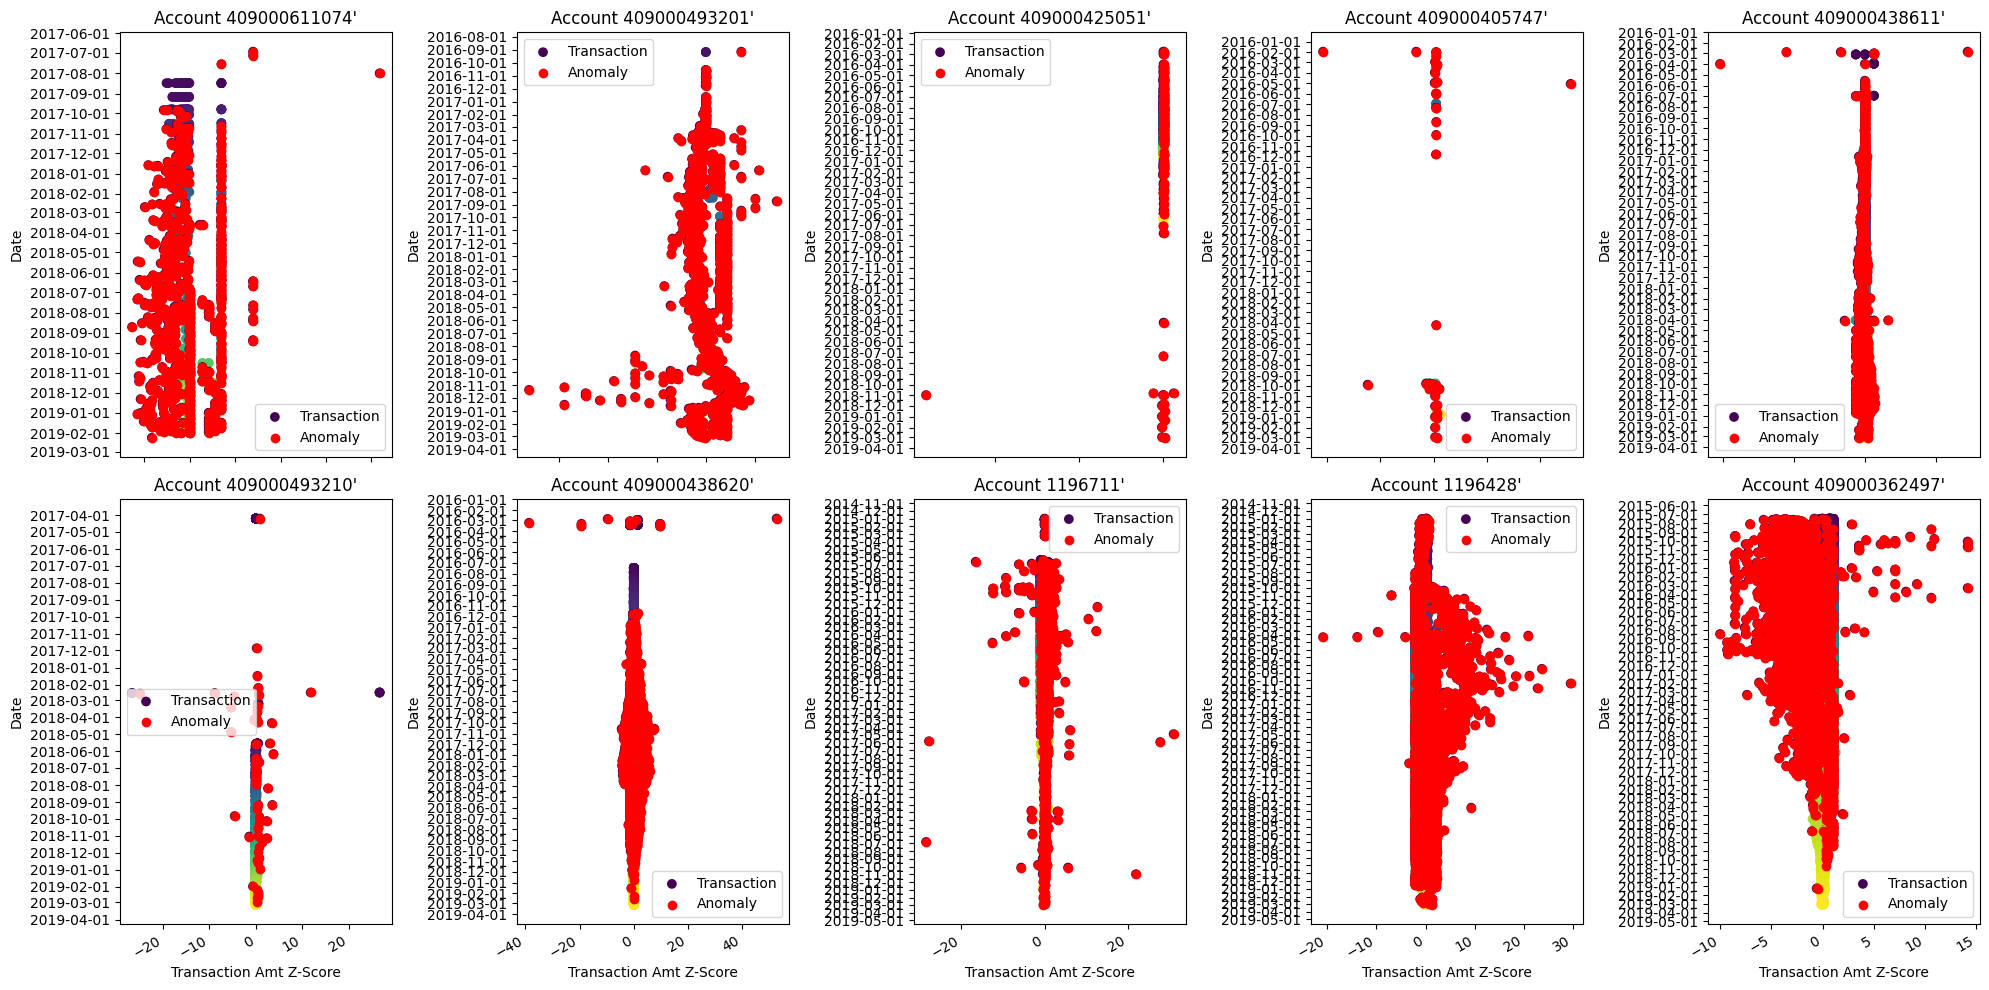

In [332]:
# Set up 2x5 plot grid for transactions
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

# Collect statistics
all_stats = []

# Plot transactions for each account in the grid
for i, account_no in enumerate(account_numbers[:10]):
    account_df, stats = dbscan_stats(df, account_no)
    all_stats.append(stats)
    plot_transactions(account_df, axs[i], account_no)

# Hide any unused subplots
for j in range(len(account_numbers), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [334]:
# statistics
statistics_df = pd.DataFrame(all_stats)
print("Statistics of DBSCAN Predicted Normal Transactions:")
(statistics_df)

Statistics of DBSCAN Predicted Normal Transactions:


,Account No,min_normal,max_normal,mean_normal,std_normal,anomaly_percentage
0,409000611074',-1.052445,1.391966,0.067701,0.613130,70.814273
1,409000493201',-0.483862,1.517056,0.224505,0.365100,90.996169
2,409000425051',-0.080233,0.037648,0.035800,0.004705,23.566085
3,409000405747',-0.280765,0.281041,0.035132,0.162939,78.431373
4,409000438611',-2.547927,2.547901,0.103964,0.315488,24.520488
5,409000493210',-26.694766,26.693816,0.001131,0.916534,1.097439
6,409000438620',-3.146669,4.527074,-0.012624,0.181085,12.122789
7,1196711',-0.920641,1.223444,-0.010339,0.623593,12.101367
8,1196428',-2.087763,2.461400,-0.065774,0.588698,6.847209
9,409000362497',-4.683917,1.286169,0.217773,0.443764,12.138070


In [335]:
# Calculate and display average values of all columns (except 'Account No')
average_values_dbscan = statistics_df.drop(columns=['Account No']).mean()
print('\nAverage Performance of DBSCAN')
print(average_values_dbscan)


Average Performance of DBSCAN
min_normal            -4.197899
max_normal             4.196752
mean_normal            0.059727
std_normal             0.421504
anomaly_percentage    33.263526
dtype: float64


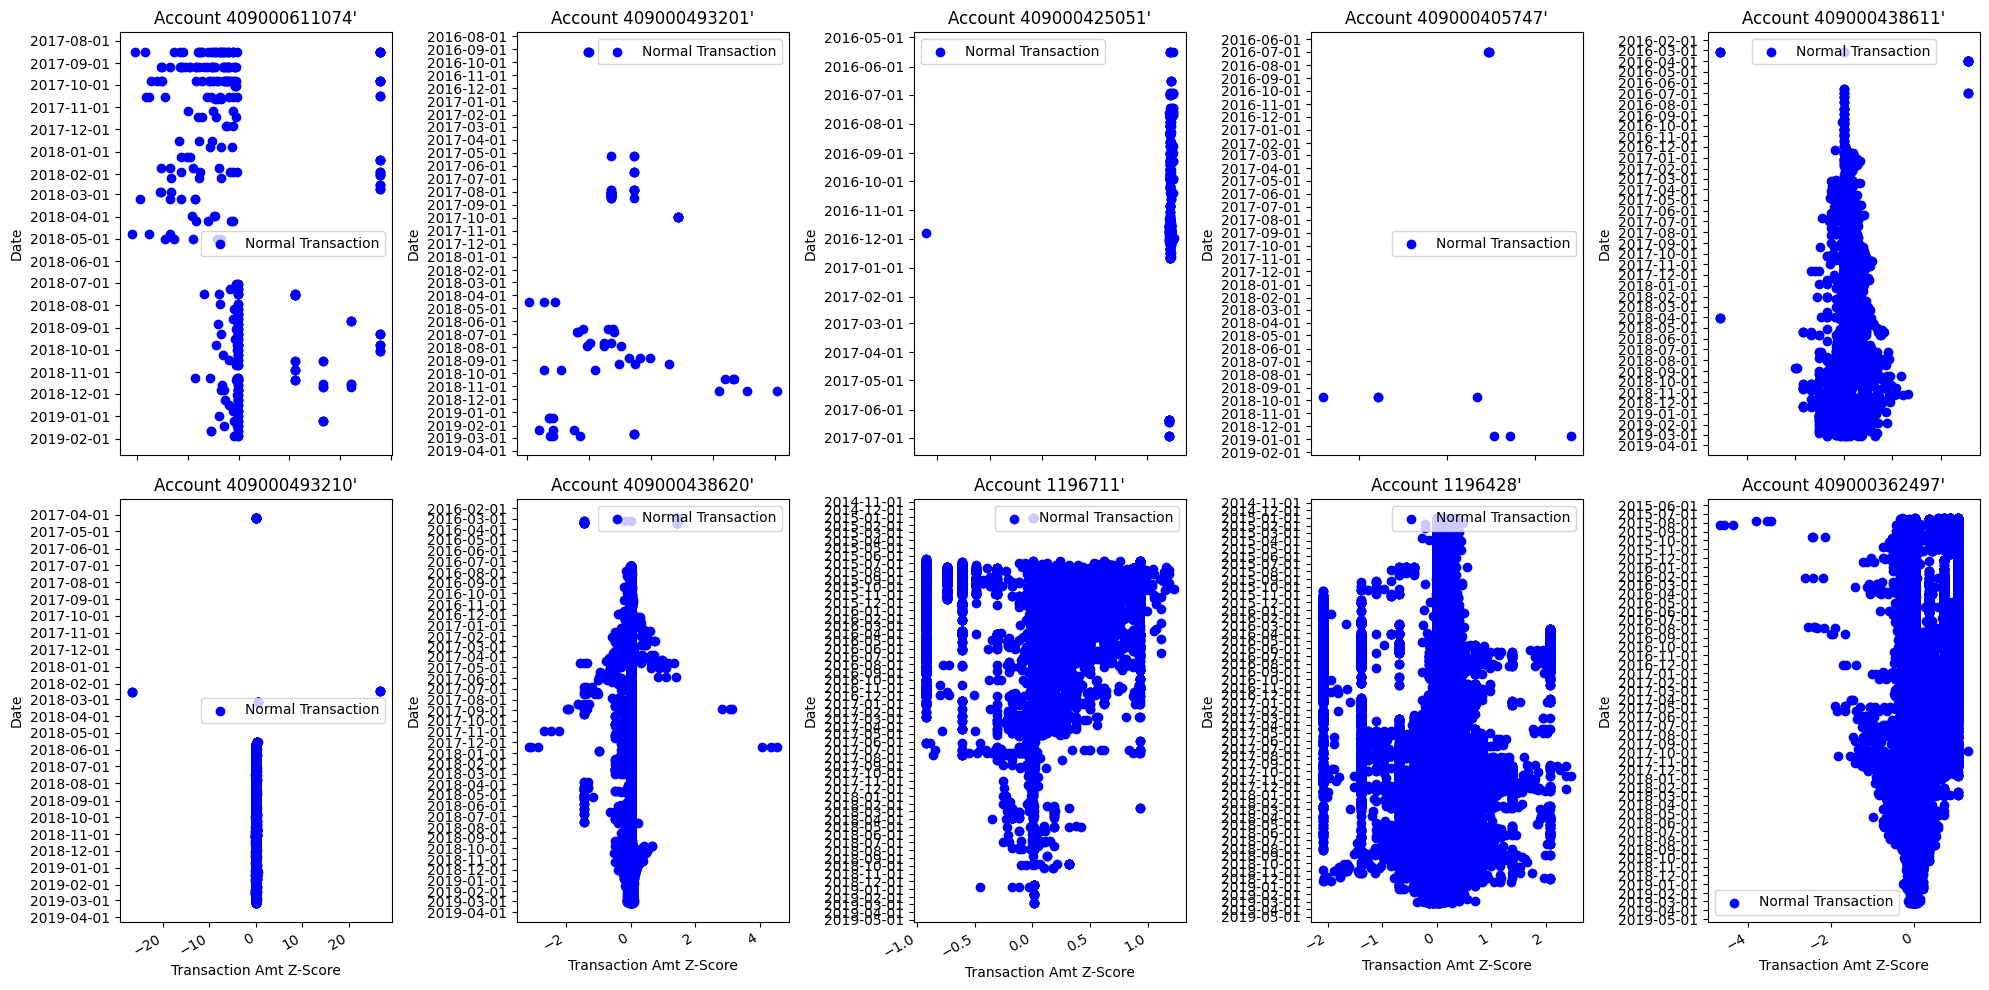

In [336]:
# normal transactions
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

for i, account_no in enumerate(account_numbers[:10]):
    account_df, _ = dbscan_stats(df, account_no)
    plot_normal_transactions(account_df, axs[i], account_no)

for j in range(len(account_numbers), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Gaussian Mixture Model

In [337]:
from sklearn.mixture import GaussianMixture

In [338]:
gmm = GaussianMixture(n_components=2, random_state=42)
df['transaction_amt_zscore'] = df['transaction_amt_zscore'].values.reshape(-1, 1)
gmm.fit(df['transaction_amt_zscore'].values.reshape(-1, 1))

log_likelihood = gmm.score_samples(df['transaction_amt_zscore'].values.reshape(-1, 1))
threshold = np.percentile(log_likelihood, 10)  
df['anomaly'] = log_likelihood < threshold

# Step 4: Calculate statistics for normal transactions
stats = []
accounts = df['Account No'].unique()

for account in accounts:
    account_df = df[df['Account No'] == account]
    normal_transactions = account_df[account_df['anomaly'] == False]['transaction_amt_zscore']
    
    min_val = normal_transactions.min()
    max_val = normal_transactions.max()
    mean_val = normal_transactions.mean()
    std_val = normal_transactions.std()
    percentage_anomalous = 100 * (account_df['anomaly'].sum() / len(account_df))
    
    stats.append({
        'Account No': account,
        'min_normal': min_val,
        'max_normal': max_val,
        'mean_normal': mean_val,
        'std_normal': std_val,
        'anomaly_percentage': percentage_anomalous
    })

stats_df = pd.DataFrame(stats)

In [339]:
# Function to plot the transactions for each account using the computed statistics
def plot_transactions(account_df, ax, account_no):
    # Plotting
    scatter = ax.scatter(account_df['transaction_amt_zscore'], account_df['date'], c=account_df['anomaly'], cmap='viridis', label='Transaction')
    
    # Highlight anomalies
    anomalies = account_df[account_df['anomaly'] == True]
    ax.scatter(anomalies['transaction_amt_zscore'], anomalies['date'], color='red', label='Anomaly')

    # Format the date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.figure.autofmt_xdate()

    # Invert y-axis
    ax.invert_yaxis()

    ax.set_title(f'Account {account_no}')
    ax.set_xlabel('Transaction Amt Z-Score')
    ax.set_ylabel('Date')
    ax.legend()

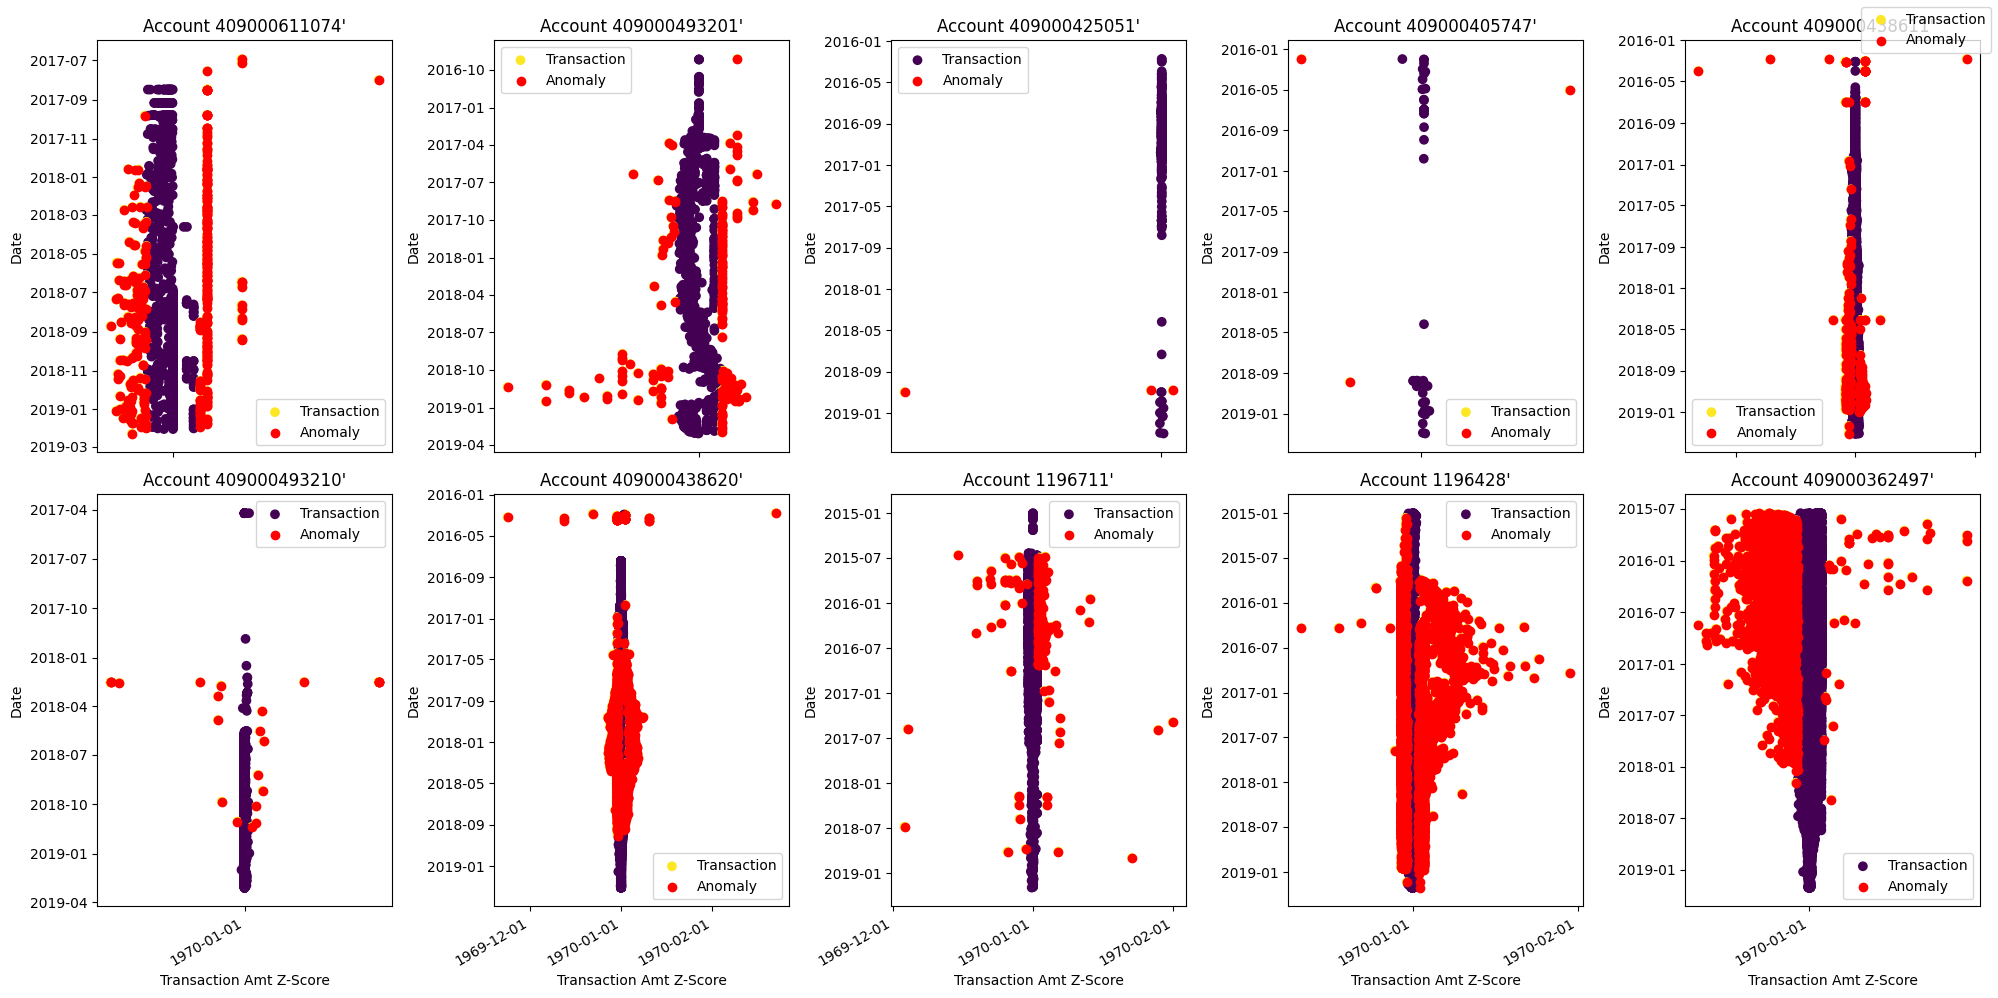

In [340]:
# Step 5: Plot the transactions for each unique account in a 2x5 grid format
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i, account in enumerate(accounts[:10]):
    account_df = df[df['Account No'] == account]
    plot_transactions(account_df, axs.flatten()[i], account)

for j in range(len(accounts), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

# Adjust layout and add legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.tight_layout()
plt.show()

In [342]:
# Display the statistics table
(stats_df)

,Account No,min_normal,max_normal,mean_normal,std_normal,anomaly_percentage
0,409000611074',-1.077243,0.834708,-0.218607,0.437833,34.949680
1,409000493201',-1.060877,1.053290,-0.055083,0.501059,18.582375
2,409000425051',-0.167288,0.238162,0.035263,0.019160,0.374065
3,409000405747',-0.655302,0.281041,0.031031,0.157091,5.882353
4,409000438611',-1.070137,1.060694,0.045408,0.332153,6.168265
5,409000493210',-0.623342,0.940430,-0.000972,0.052156,0.382441
6,409000438620',-1.062812,1.060792,-0.020799,0.164579,8.123978
7,1196711',-0.921555,1.056491,-0.016081,0.611686,1.974184
8,1196428',-1.076407,1.063139,0.030620,0.225593,13.743619
9,409000362497',-1.078259,1.065052,0.205821,0.458078,7.382708


In [343]:
# Calculate and display average values of all columns (except 'Account No')
average_values_gmm = stats_df.drop(columns=['Account No']).mean()
print('\nAverage Performance of GMM')
print(average_values_gmm)


Average Performance of GMM
min_normal           -0.879322
max_normal            0.865380
mean_normal           0.003660
std_normal            0.295939
anomaly_percentage    9.756367
dtype: float64


## Results

In [344]:
final_df = pd.concat([average_values_if, average_values_dbscan, average_values_gmm], axis=1)
final_df.columns = ['IF', 'DBSCAN', 'GMM']

print("Overall Performance")
print(final_df)

Overall Performance
                          IF     DBSCAN       GMM
min_normal         -0.998963  -4.197899 -0.879322
max_normal          1.998777   4.196752  0.865380
mean_normal         0.026237   0.059727  0.003660
std_normal          0.373639   0.421504  0.295939
anomaly_percentage  9.246106  33.263526  9.756367


## Discussion
### <br> 1) IF and GMM showed expected performace for the entire dataset, DBSCAN deviated as it failed to make any strong clusters.

## Further Ideas

### <br> 1) If a set of accounts' transactions in this dataset can be classified as completely normal/non-anomalous, we can train an LSTM-Autoencoder model, which can then be used to detect anomalies.
### <br> 2) As seen here, no use of Cheque column has been demonstrated. This is because there are very few rows that contain the information of Cheques, so in this dataset, they cannot be relied upon for the detection of anomalies.

## References:
<br> 1) https://www.kaggle.com/code/emmadubois/dubois-emma-test-karmen
<br> 2) https://unit8.com/resources/a-guide-to-building-a-financial-transaction-anomaly-detector/
<br> 3) https://medium.com/@zhonghong9998/anomaly-detection-in-time-series-data-using-lstm-autoencoders-51fd14946fa3
<br> 4) https://medium.com/@venujkvenk/anomaly-detection-techniques-a-comprehensive-guide-with-supervised-and-unsupervised-learning-67671cdc9680